Using MPS device
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3394864.00it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 182847.99it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4040425.57it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1350526.64it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

(49998, 28, 28) (10002, 28, 28) (10000, 28, 28)
Training with batch size: 1
Training with batch size: 10
Training with batch size: 100
Training with batch size: 1000


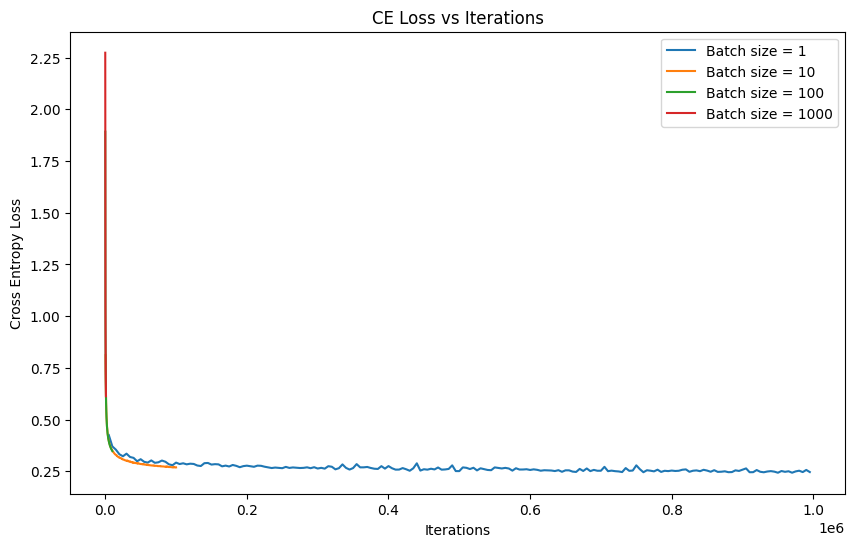

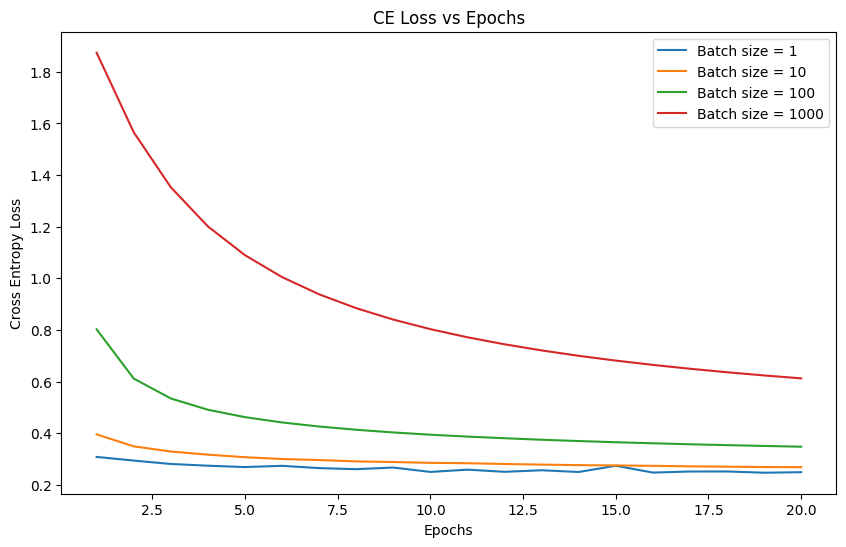

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Check if MPS (Metal Performance Shaders) is available for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU")

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

X_train_full = train_dataset.data.numpy()
y_train_full = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

# Normalize images
X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1667, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)  # Ensure shapes are correct

# Flatten the data
X_train_flat = X_train.reshape(-1, 28 * 28)
X_val_flat = X_val.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

# Convert data to tensors and move to the device
X_train_tensor = torch.from_numpy(X_train_flat).to(device)
y_train_tensor = torch.from_numpy(y_train).long().to(device)

X_val_tensor = torch.from_numpy(X_val_flat).to(device)
y_val_tensor = torch.from_numpy(y_val).long().to(device)

X_test_tensor = torch.from_numpy(X_test_flat).to(device)
y_test_tensor = torch.from_numpy(y_test).long().to(device)

# Define logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs  # CrossEntropyLoss expects raw logits

input_dim = 28 * 28
num_classes = 10

# List of batch sizes
batch_sizes = [1, 10, 100, 1000]

# Number of epochs
epochs = 20

# Storing results for each batch size
ce_losses_per_iteration = {}
ce_losses_per_epoch = {}

# Train the model for each batch size
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")

    model = LogisticRegressionModel(input_dim, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    n_iterations_per_epoch = len(X_train_tensor) // batch_size
    total_iterations = n_iterations_per_epoch * epochs

    ce_loss_iterations = []
    ce_loss_epochs = []

    iteration_count = 0
    iterations_per_log = max(5000 // batch_size, 1)

    # Training loop
    for epoch in range(epochs):
        # Shuffle the data
        indices = np.arange(len(X_train_tensor))
        np.random.shuffle(indices)

        X_train_shuffled = X_train_tensor[indices]
        y_train_shuffled = y_train_tensor[indices]

        # Mini-batch training
        for i in range(0, len(X_train_shuffled), batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            iteration_count += 1

            # Every (5000 / batch_size) iterations, compute CE loss
            if iteration_count % iterations_per_log == 0:
                with torch.no_grad():
                    outputs_train = model(X_train_tensor)
                    loss_train = criterion(outputs_train, y_train_tensor)
                    ce_loss_iterations.append(loss_train.item())

        # At the end of each epoch, calculate CE loss for the entire training set
        with torch.no_grad():
            outputs_train = model(X_train_tensor)
            loss_train = criterion(outputs_train, y_train_tensor)
            ce_loss_epochs.append(loss_train.item())

    # Store losses for each batch size
    ce_losses_per_iteration[batch_size] = ce_loss_iterations
    ce_losses_per_epoch[batch_size] = ce_loss_epochs

# Plot CE loss vs iterations
plt.figure(figsize=(10, 6))
for batch_size, losses in ce_losses_per_iteration.items():
    iterations_per_log = max(5000 // batch_size, 1)
    iterations = np.arange(1, len(losses) + 1) * iterations_per_log
    plt.plot(iterations, losses, label=f'Batch size = {batch_size}')

plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Iterations')
plt.legend()
plt.show()

# Plot CE loss vs epochs
plt.figure(figsize=(10, 6))
for batch_size, losses in ce_losses_per_epoch.items():
    epochs_range = np.arange(1, len(losses) + 1)
    plt.plot(epochs_range, losses, label=f'Batch size = {batch_size}')

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Epochs')
plt.legend()
plt.show()


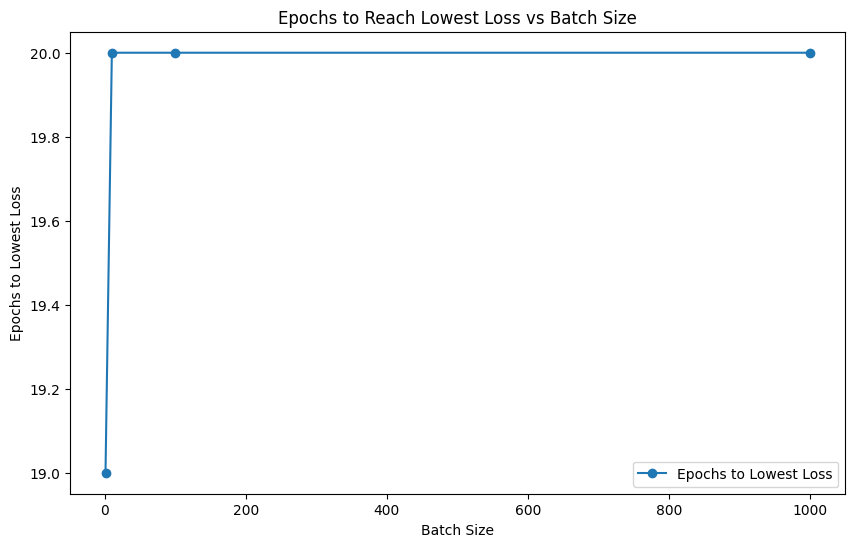

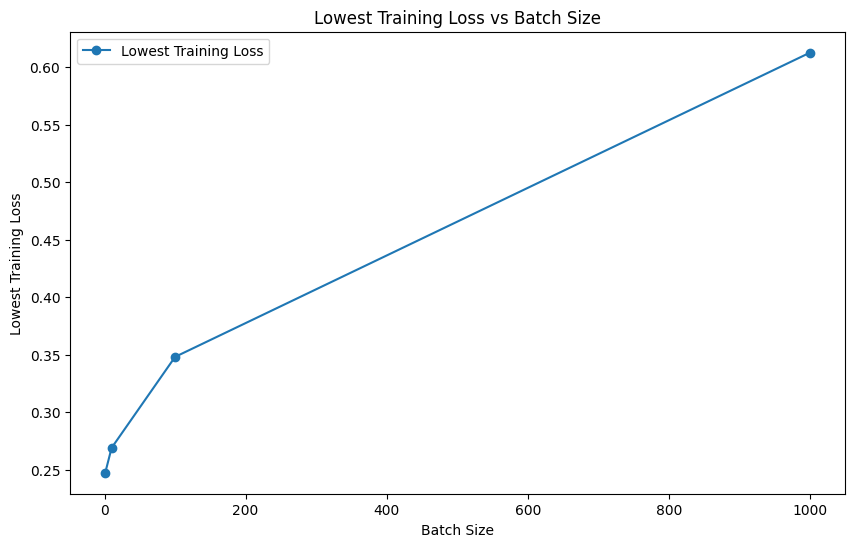

In [2]:
# Store results for number of epochs to lowest loss and the lowest loss achieved
epochs_to_lowest_loss = []
lowest_losses = []

for batch_size, losses in ce_losses_per_epoch.items():
    lowest_loss = min(losses)
    epoch_to_lowest_loss = losses.index(lowest_loss) + 1  # +1 because epoch indexing starts from 1
    epochs_to_lowest_loss.append(epoch_to_lowest_loss)
    lowest_losses.append(lowest_loss)

# Plot number of epochs to reach the lowest loss vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, epochs_to_lowest_loss, marker='o', label='Epochs to Lowest Loss')
plt.xlabel('Batch Size')
plt.ylabel('Epochs to Lowest Loss')
plt.title('Epochs to Reach Lowest Loss vs Batch Size')
plt.legend()
plt.show()

# Plot lowest training loss vs batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, lowest_losses, marker='o', label='Lowest Training Loss')
plt.xlabel('Batch Size')
plt.ylabel('Lowest Training Loss')
plt.title('Lowest Training Loss vs Batch Size')
plt.legend()
plt.show()

Using MPS device
(49998, 28, 28) (10002, 28, 28) (10000, 28, 28)

Training with λ = 0

Training with λ = 0.01

Training with λ = 0.1

Training with λ = 1


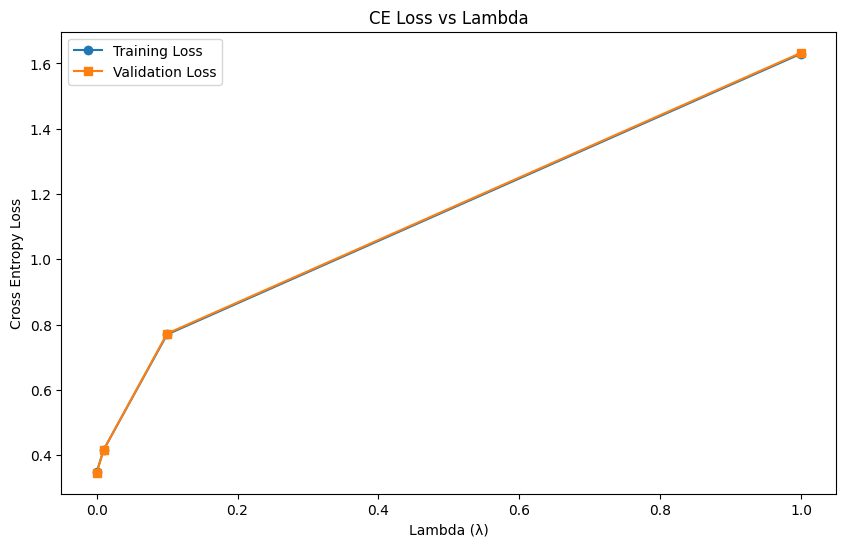

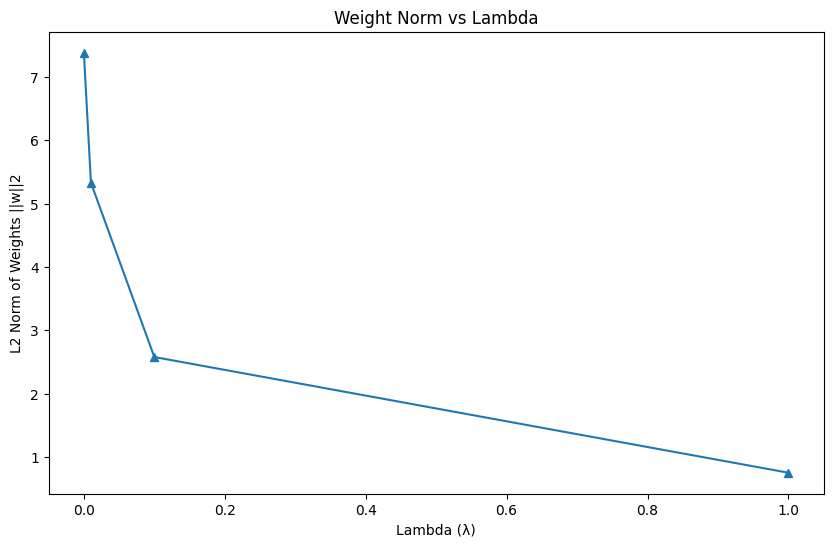

Best λ based on validation loss: 0

Retraining on combined data with λ = 0


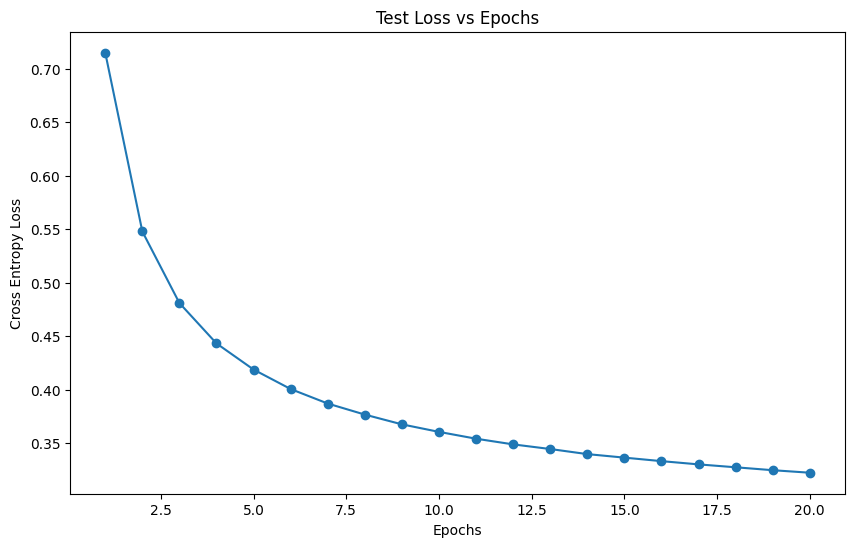

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Check if MPS (Metal Performance Shaders) is available for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU")

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

X_train_full = train_dataset.data.numpy()
y_train_full = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

# Normalize images
X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1667, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)  # Ensure shapes are correct

# Flatten the data
X_train_flat = X_train.reshape(-1, 28 * 28)
X_val_flat = X_val.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

# Convert data to tensors and move to the device
X_train_tensor = torch.from_numpy(X_train_flat).to(device)
y_train_tensor = torch.from_numpy(y_train).long().to(device)

X_val_tensor = torch.from_numpy(X_val_flat).to(device)
y_val_tensor = torch.from_numpy(y_val).long().to(device)

X_test_tensor = torch.from_numpy(X_test_flat).to(device)
y_test_tensor = torch.from_numpy(y_test).long().to(device)

# Define logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs  # CrossEntropyLoss expects raw logits

input_dim = 28 * 28
num_classes = 10

# Selected batch size from previous part
batch_size = 100

# Number of epochs
epochs = 20

# List of lambda values for weight decay
lambda_values = [0, 0.01, 0.1, 1]

# Storing results for each lambda
train_losses = []
val_losses = []
weight_norms = []

for lambda_reg in lambda_values:
    print(f"\nTraining with λ = {lambda_reg}")

    model = LogisticRegressionModel(input_dim, num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=lambda_reg)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epochs):
        # Shuffle the data
        indices = np.arange(len(X_train_tensor))
        np.random.shuffle(indices)

        X_train_shuffled = X_train_tensor[indices]
        y_train_shuffled = y_train_tensor[indices]

        # Mini-batch training
        model.train()
        for i in range(0, len(X_train_shuffled), batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

    # Compute CE loss on training set
    model.eval()
    with torch.no_grad():
        outputs_train = model(X_train_tensor)
        loss_train = criterion(outputs_train, y_train_tensor)
        train_losses.append(loss_train.item())

        # Compute CE loss on validation set
        outputs_val = model(X_val_tensor)
        loss_val = criterion(outputs_val, y_val_tensor)
        val_losses.append(loss_val.item())

    # Compute L2 norm of weights
    w_norm = 0.0
    for param in model.parameters():
        w_norm += torch.norm(param).item() ** 2
    w_norm = np.sqrt(w_norm)
    weight_norms.append(w_norm)

# Plot CE loss vs lambda
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, train_losses, marker='o', label='Training Loss')
plt.plot(lambda_values, val_losses, marker='s', label='Validation Loss')
plt.xlabel('Lambda (λ)')
plt.ylabel('Cross Entropy Loss')
plt.title('CE Loss vs Lambda')
plt.legend()
plt.show()

# Plot ||w||2 vs lambda
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, weight_norms, marker='^')
plt.xlabel('Lambda (λ)')
plt.ylabel('L2 Norm of Weights ||w||2')
plt.title('Weight Norm vs Lambda')
plt.show()

# Find the best lambda (minimum validation loss)
best_lambda_index = np.argmin(val_losses)
best_lambda = lambda_values[best_lambda_index]
print(f"Best λ based on validation loss: {best_lambda}")

# Part (d): Train on combined training and validation set using the best λ
print(f"\nRetraining on combined data with λ = {best_lambda}")

# Combine training and validation sets
X_combined = np.concatenate((X_train_flat, X_val_flat), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

X_combined_tensor = torch.from_numpy(X_combined).to(device)
y_combined_tensor = torch.from_numpy(y_combined).long().to(device)

# Initialize model
model = LogisticRegressionModel(input_dim, num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=best_lambda)
criterion = nn.CrossEntropyLoss()

test_losses = []

# Training loop
for epoch in range(epochs):
    # Shuffle the data
    indices = np.arange(len(X_combined_tensor))
    np.random.shuffle(indices)

    X_train_shuffled = X_combined_tensor[indices]
    y_train_shuffled = y_combined_tensor[indices]

    # Mini-batch training
    model.train()
    for i in range(0, len(X_train_shuffled), batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Compute CE loss on test set
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        loss_test = criterion(outputs_test, y_test_tensor)
        test_losses.append(loss_test.item())

# Plot CE loss on test set vs epochs
plt.figure(figsize=(10, 6))
epochs_range = np.arange(1, epochs + 1)
plt.plot(epochs_range, test_losses, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Test Loss vs Epochs')
plt.show()